# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

from keijzer import setup_multi_gpus, create_corr_matrix, reduce_memory, resample_df, df_to_lstm_format

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline
sns.set()

Using TensorFlow backend.
/opt/jupyterhub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


ModuleNotFoundError: No module named 'keijzer'

In [ ]:
# Setup multi GPU usage
num_gpu = setup_multi_gpus()

# Load data

In [ ]:
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed/all_dwellings_combined_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.dropna()

# Get an hour dataframe
df = resample_df(df, 'D', combine_all_dwellings=True)

#df['year'] = df.index.year
#df['month'] = df.index.month
#df['day'] = df.index.day
#df['hour'] = df.index.hour #create column containing the hour
#df['dayofweek'] = df.index.dayofweek
#df['season'] = (df.index.month%12 + 3)//3 # Calculates the season (categorical)


In [ ]:
df.head()

In [ ]:
fig = create_corr_matrix(df, '', False)

# Select data to use

In [ ]:
data = df
#data = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'dwelling'], axis=1) # Not needed
data = data.drop(['dwelling'], axis=1) # Not needed
data = data.drop(['WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1) # Drop weather columns which contain correlated information, keep only one type
#sns.heatmap(data.corr(), annot=True)

data = data.drop(['ePower', 'ePowerReturn'], axis=1) # Drop if want to predict gasPower

# Drop columns with that have a |corr| > 0.1 with T
data = data.drop(['U', 'N', 'Q', 'DD'], axis=1)


#data = data[data['T'] < 0] #filter data based on condition
#data = data.reset_index()
magnitude = 1
data['gasPower'] = data['gasPower']*10**magnitude
data = data.dropna()

fig = create_corr_matrix(data, '', True, size=(5,5))

print('Len of data: ', len(data))

In [ ]:
plt.plot(data.index, data['gasPower'], '.-', color='r', label='Original data')
plt.xlabel('Temperature [°C]')
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)
plt.legend()
plt.xticks(rotation=45)

# Preprocessing

In [ ]:
"""
Add a copy of gasPower column, so previous gasPower values are also in X_reshaped
"""
data['gasPower_copy'] = data['gasPower']
data.head()

# Preprocessing, data to lstm format

In [ ]:
look_back = 5 # D -> 5
num_features = data.shape[1] - 1
output_dim = 1
test_size = 0.5

X_train, y_train, X_test, y_test = df_to_lstm_format(df=data, test_size=test_size, look_back=look_back, target_column='gasPower', scale_X=True)

In [14]:
def abs_percentage_error(y_true, y_pred):
    import keras.backend as K
    """
    Returns the absolute value of the difference between y_true and y_pred (in percentage).
    For examples on losses see:
    https://github.com/keras-team/keras/blob/master/keras/losses.py
    """
    return (K.abs(y_true - y_pred) / K.abs(y_pred)) * 100

In [ ]:
hidden_nodes = 35 # 35
epochs = 1000

# Create model
model = Sequential()

model.add(LSTM(hidden_nodes, input_shape=(look_back, num_features), kernel_initializer='TruncatedNormal'))
model.add(LeakyReLU())

#model.add(Dense(35, kernel_initializer='TruncatedNormal'))
#model.add(LeakyReLU())

#N = 256 #45  
#for i in range(4):
#    model.add(Dense(N-i*4, kernel_initializer='TruncatedNormal'))
#    model.add(LeakyReLU())
    #model.add(Dropout(0.5))


model.add(Dense(units=output_dim, kernel_initializer='TruncatedNormal'))
#model.add(Activation('linear'))

model = multi_gpu_model(model, gpus=num_gpu)

sgd = SGD(lr=0.005, momentum=0.9, decay=0, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower

# compile & fit
model.compile(optimizer='sgd', loss = ['mse'], metrics=['mse', abs_percentage_error])

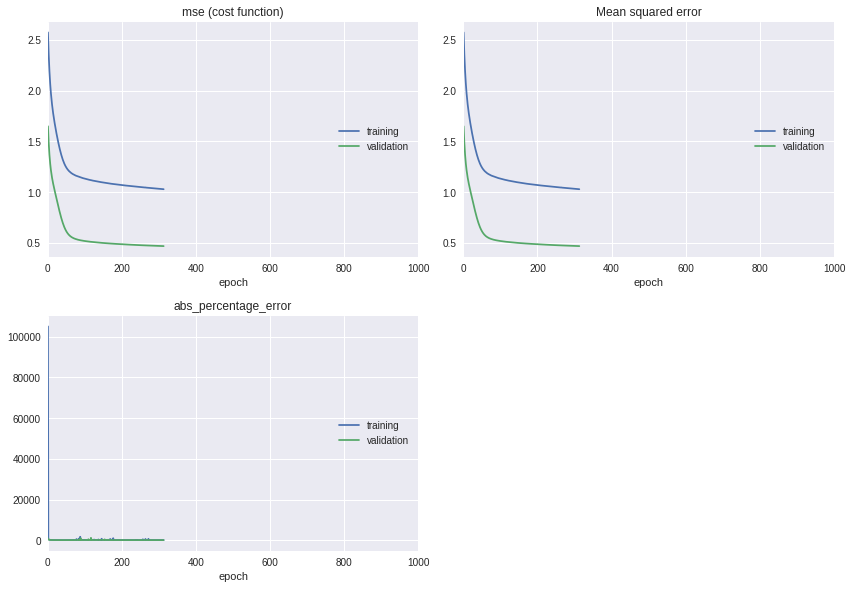

 - 1s - loss: 1.0284 - mean_squared_error: 1.0284 - abs_percentage_error: 85.6485 - val_loss: 0.4677 - val_mean_squared_error: 0.4677 - val_abs_percentage_error: 73.1018
Epoch 314/1000


In [ ]:
early_stopping_monitor = EarlyStopping(patience=1000)



model.fit(X_train, y_train, epochs=epochs, batch_size=int(len(X_train)/4), validation_data=(X_test, y_test),
         verbose=2, callbacks=[PlotLossesKeras(), early_stopping_monitor])

print(model.summary())

In [ ]:
y_preds = model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*test_size)
x = data[split_index:]
len(y_true), len(x)

In [ ]:
datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='r', label='Real values', alpha=0.5)
plt.plot(x.index, y_preds, '.-', color='b', label='Predicted values')

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse = model.evaluate(X_test, y_test)[1]
perc = model.evaluate(X_test, y_test)[2]

plt.title('LSTM result \n MSE = %.2f \n Avarage error = %.1f [%%]' % (mse, perc), fontsize = 14)

plt.savefig('figures/LSTM result.png', dpi=1200)

In [ ]:
plt.savefig('figures/LSTM result.png', dpi=1200)
print('FINISHED')